### Same as Untitled8 but using updated info table for growth rate column - seems to help.

In [1]:
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
%Rdevice svg
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
#%run -i read_counts.py
all_freqs = pickle.load(open('all_freqs.pkl', 'rb'))

In [3]:
sample_info = pd.read_excel('Sample_Info_FIXED2.xlsx') ##,skiprows=[0])
sample_info = sample_info.drop( ['growth rate per h (OLD)', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Sample name.1'], 1)
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
info = sample_infos['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sizeme(info.head(3),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_US-1505885,Sample_US-1505885,Labcorp,US-1505885,PS 37 C log 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",sulfate respiration/growth,pyruvate 80mM,pyruvate,NaN,sulfate,0.13,37,D vulgaris Hildenborugh,NaN
Sample_US-1505888,Sample_US-1505888,Labcorp,US-1505888,LS 37C log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,0.11,37,D vulgaris Hildenborugh,NaN
Sample_US-1505895,Sample_US-1505895,Labcorp,US-1505895,LS 37C e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0.00,37,D vulgaris Hildenborugh,0


### Identify groups of replicates in the measurements -- using groupby

In [4]:
#info_tmp = info[info.columns[np.hstack([4,np.arange(6,14)])]]  ##.duplicated()
group_cols = info.columns[np.hstack([4,6,7,8,9,11,12,13,14])].values.astype(str).tolist()
#grouped = info.groupby(info.columns[np.hstack([4,np.arange(6,14)])].values)
#group_cols = ['cultivation type', 'Description/condition details',
#             'Description/condition details -2', 'carbon source', 'electron donor',
#             'concentration (mM)', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
print group_cols
grouped = info.groupby(group_cols, axis=0)
print len(grouped.groups), info.shape, info[group_cols].drop_duplicates().shape
#print grouped.groups[grouped.groups.keys()[0]]
print [len(i) for i in grouped.groups.values()]
col_groups = grouped.groups.values()
for i in grouped.groups.values():
    print i
    #print info.ix[i]['Description/condition details'].values
col_groups = grouped.groups.values()

['cultivation type', 'Description/condition details', 'Description/condition details -2', 'carbon source', 'electron donor', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
23 (57, 16) (23, 9)
[3, 3, 3, 3, 3, 5, 3, 1, 2, 3, 3, 2, 3, 2, 1, 2, 2, 1, 2, 3, 1, 4, 2]
['Sample_US-1510865', 'Sample_US-1510891', 'Sample_US-1510901']
['Sample_US-1505895', 'Sample_US-1505949', 'Sample_US-1510877']
['Sample_US-1510871', 'Sample_US-1510882', 'Sample_US-1510888']
['Sample_US-1510876', 'Sample_US-1510894', 'Sample_US-1510897']
['Sample_US-1505897', 'Sample_US-1505963', 'Sample_US-1510881']
['Sample_US-1510845', 'Sample_US-1510852', 'Sample_US-1510859', 'Sample_US-1510864', 'Sample_US-1510895']
['Sample_US-1505946', 'Sample_US-1505967', 'Sample_US-1505985']
['Sample_US-1510827']
['Sample_US-1510854', 'Sample_US-1510870']
['Sample_US-1505885', 'Sample_US-1506000', 'Sample_US-1510880']
['Sample_US-1505888', 'Sample_US-1505998', 'Sample_US-1510873']
['Sample_US-1510874', 'Sample_US-1510892

## OK, idea: remove all replicates of a given measurement, run Boruta to get big, best subset of variables that classify, then random forest (lots of trees) using those variables to get classifier. Test (predict) the random forest on the left-out measurements.

### Now do it for all test cases! -- i.e., all replicate sets

In [5]:
x = all_freqs['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
print x.shape
cols = grouped.groups.values()[0]
xx = np.log10(x+1e-1).fillna( 0 )

(3648, 57)


In [13]:
%Rpush x
%Rpush info
%R colnames(x) <- gsub('X..','',gsub('...1.','',colnames(x),fixed=T),fixed=T)
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))
#%R save(col_groups,file='qqq')

[1] 23


In [8]:
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))

[1] 23


In [10]:
%%R -n
#load('Untitled5.RData')
#load('Untitled6.RData')
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)

do_it <- function(cond_type, x, cols_exclude=NULL, genes_exclude=NULL, n_trees=100000) {
    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    #cat(cond_type, length(levels(Y)), '\n')
    names(Y) <- info$Sample.name

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    B.temp1a <- Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0)
    features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
        
    rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    tmp <- list(predicted=predict(rf.temp1a, t(x[features,cols2,drop=F])), actual=Y[cols_exclude], features=features)
    
    return(tmp)
}
NULL

NULL


In [14]:
%%R 
results = list()
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
    tmp <- mclapply( col_groups, function(cols) {
        cols = unlist(cols)
        tmp <- do_it(cond_type, x.ranks, cols)
        #cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        return(tmp)
    }, mc.preschedule=F )
    cat(cond_type, mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual'))), '\n')
    results[[cond_type]] <- tmp
}


Error in FUN(X[[i]], ...) : subscript out of bounds


In [27]:
%R print(sapply(results,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
%R print(sapply(results,function(tmp)length(levels(unlist(lapply(tmp,'[[','actual'))))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results

   electron_donor electron_acceptor       temperature       growth_rate 
        0.9824561         0.8070175         0.8421053         0.6842105 


   electron_donor electron_acceptor       temperature       growth_rate 
                3                 3                 2                 3 


### See which classes are most misclassified (growth_rate).
#### looks like fast growth is most often misclassified as no growth (and vice versa).

In [ ]:
%%R -n
tmp1=unlist(lapply(lapply(results$growth_rate,'[[','predicted'),as.character))
tmp2=unlist(lapply(lapply(results$growth_rate,'[[','actual'),as.character))
print(table(tmp2[tmp1!=tmp2]))   ## which actual classes are most frequently misclassified
print(table(tmp1[tmp1!=tmp2]))   ## which predicted classes are they most frequently misclassified as
cbind(predicted=tmp1[tmp1!=tmp2],actual=tmp2[tmp1!=tmp2])   ## misclassification pairs (predicted, actual)

### For comparison, do it for the full data sets in which we did not leave any conditions out

In [11]:
%%R
    results_noleaveout = list()
    for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
        if (cond_type == 'growth_rate') {
            gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
            Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
        } else if (cond_type == 'electron_donor') {
            Y <- as.factor(as.character(info$electron.donor))
        } else if (cond_type == 'electron_acceptor') {
            Y <- as.factor(as.character(info$electron.acceptor))
        } else if (cond_type == 'temperature') {
            Y <- as.factor(as.character(info$T0C == 37))
        } else if (cond_type == 'all') {
            Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
            Y2 <- as.character(info$electron.donor)
            Y3 <- as.character(info$electron.acceptor)
            Y4 <- as.character(info$T0C == 37)
            Y <- as.factor(paste(Y1, Y2, Y3, Y4))
        }
        cat(cond_type, length(levels(Y)), '\n')

        B.temp1a <- Boruta(t(x.ranks), Y, getImp=getImpFerns, ferns=100000, doTrace=0)
        features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
        
        rf.temp1a <- randomForest(t(x.ranks[features,]), Y, importance=T, ntree=100000, do.trace=F)
        tmp = list(predicted=predict(rf.temp1a), actual=Y, features=features)

        ##print(lapply(tmp,function(i)mean(i$predicted==i$actual)))
        cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        results_noleaveout[[cond_type]] <- tmp
    }

electron_donor 3 
electron_donor 1 
electron_acceptor 3 
electron_acceptor 0.9298246 
temperature 2 
temperature 0.9649123 
growth_rate 3 
growth_rate 0.877193 
NULL


In [ ]:
%R print(apply(sapply(results_noleaveout,'[[','predicted') == sapply(results_noleaveout,'[[','actual'),2,mean))
%R print(sapply(results_noleaveout,function(tmp)length(levels(tmp$actual))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results_noleaveout
%R rm(rf.temp1a,B.temp1a); save.image("Untitled9.RData")

### Let's try the removing of the lowest-expressed genes incrementally and see how training/testing works for electron_donor conditions:

##### lets do it by quantiles first, just to see (try 8 quantiles???):

In [ ]:
%%R
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)
#cond_type <- 'electron_donor'
qqq <- list()
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
tmp_lst <- lapply( 1:length(col_groups), function(col) {
    #cols = unlist(col_groups[[13]])
    cols <- col_groups[[col]]
    cols <- unlist(cols)
    cols2 <- gsub('-','.',cols)   ## try a pyruvate condition  -- all predicted correctly
    mns <- apply(x.ranks[,cols2, drop=F], 1, median)
    levels <- quantile(mns, inp_quantiles)
    tmp <- mclapply( rev(levels), function(lev) {
        cat(col, 'of', length(col_groups), rev(names(levels))[which(rev(levels)==lev)], lev, sum(mns>lev), cond_type, '\n')
        xx <- x.ranks[mns > lev,, drop=F]
        ttmp <- do_it(cond_type, xx, cols)
        #cat(lev, sum(mns>lev), cond_type, mean(as.character(ttmp$predicted) == as.character(ttmp$actual)), '\n')
        return(ttmp)
    }, mc.preschedule=F )
    #print(apply(sapply(tmp,'[[','predicted') == sapply(tmp,'[[','actual'),2,mean))
    return( tmp )
} )
#print(sapply(tmp_lst,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
qqq[[cond_type]] <- tmp_lst
}

In [ ]:
%R save.image('Untitled9.RData')
#%R load('Untitled8.RData')

NULL


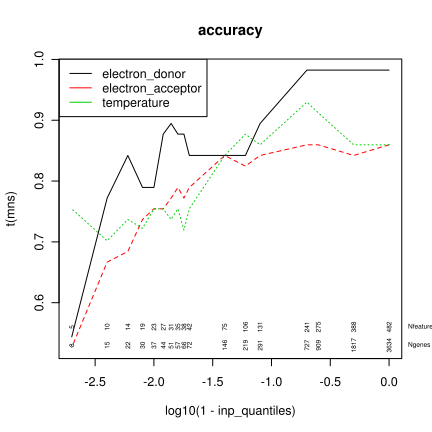

In [12]:
%%R
load('Untitled9.RData')
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
mns <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)tmp2[[lev]]$predicted==unlist(tmp2[[lev]]$actual))))))
colnames(mns)<-names(qqq$growth_rate[[1]])
mns<-mns[,ncol(mns):1]
expr_levels = quantile(apply(x.ranks,1,median),inp_quantiles)
n_genes <- sapply(expr_levels,function(lev)sum(apply(x.ranks,1,median)>lev))

n_features <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)length(tmp2[[lev]]$features))))))
colnames(n_features)<-names(qqq$growth_rate[[1]])
n_features<-n_features[,ncol(n_features):1]

matplot(log10(1-inp_quantiles),t(mns),typ='l',main='accuracy')
legend('topleft',legend=rownames(mns),lwd=1,col=1:4)
#text(log10(1-inp_quantiles), 0.5, lab=as.character(round(expr_levels)),cex=0.5,srt=90, xpd=NA)
#text(0.1, 0.5, lab='Rank', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.53, lab=as.character(n_genes),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.53, lab='Ngenes', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.56, lab=as.character(round(apply(n_features,2,mean))),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.56, lab='Nfeatures', pos=4, cex=0.5, xpd=NA)

NULL

NULL


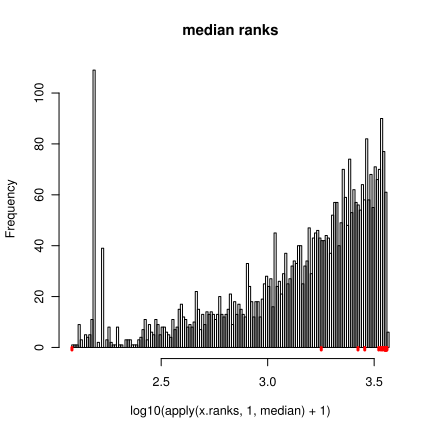

In [13]:
%%R
hist(log10(apply(x.ranks,1,median)+1),breaks=200,main='median ranks')
tmp<-sapply(expr_levels,function(i)lines(rep(log10(i+1),2),c(-1,0),col='red',lwd=3));rm(tmp);NULL

### Get list of (importance-ranked) genes for each condition...

### First -- electron donor!!!

 [1] "DVU0266" "DVU3033" "DVU3032" "DVU0265" "DVU3031" "DVU2108" "DVU2286"
 [8] "DVU2289" "DVU3027" "DVU2291" "DVU2290" "DVU0259" "DVU2292" "DVU2288"
[15] "DVU3026" "DVU3028" "DVU3030" "DVU2652" "DVU3287" "DVU2451" "DVU2783"
[22] "DVU0148" "DVU2287" "DVU0534" "DVU2297" "DVU0694" "DVU1545" "DVU0434"
[29] "DVU2293" "DVU0359"


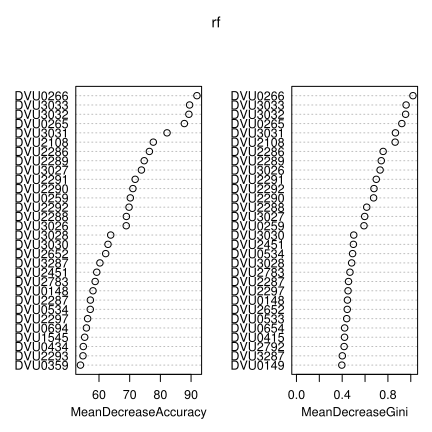

In [14]:
%%R
nlev = length(levels)
tmp = table(unlist(lapply(qqq$electron_donor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp==length(qqq$electron_donor)])
rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
varImps = varImpPlot(rf) ##; print(rf)
varImps = varImps[ order(varImps[,1], decreasing=T), ]
imp_genes = rownames(varImps)[1:30]

In [15]:
%Rpull imp_genes

query = '%22'+'%22+%22'.join(imp_genes)+'%22'
query = 'http://networks.systemsbiology.net/search?q='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

http://networks.systemsbiology.net/search?q=%22DVU0266%22+%22DVU3033%22+%22DVU3032%22+%22DVU0265%22+%22DVU3031%22+%22DVU2108%22+%22DVU2286%22+%22DVU2289%22+%22DVU3027%22+%22DVU2291%22+%22DVU2290%22+%22DVU0259%22+%22DVU2292%22+%22DVU2288%22+%22DVU3026%22+%22DVU3028%22+%22DVU3030%22+%22DVU2652%22+%22DVU3287%22+%22DVU2451%22+%22DVU2783%22+%22DVU0148%22+%22DVU2287%22+%22DVU0534%22+%22DVU2297%22+%22DVU0694%22+%22DVU1545%22+%22DVU0434%22+%22DVU2293%22+%22DVU0359%22


### Second -- electron acceptor!!!

 [1] "DVU3033" "DVU0266" "DVU3032" "DVU0265" "DVU3031" "DVU0261" "DVU0260"
 [8] "DVU0263" "DVU2108" "DVU0264" "DVU2104" "DVU2107" "DVU2286" "DVU2679"
[15] "DVU2289" "DVU3027" "DVU2291" "DVU2288" "DVU2292" "DVU2290" "DVU0262"
[22] "DVU3026" "DVU2109" "DVU3030" "DVU3028" "DVU2103" "DVU0259" "DVU2652"
[29] "DVU0267" "DVU0530"


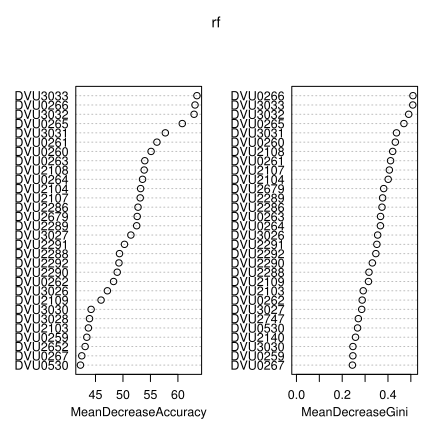

In [16]:
%%R
nlev = length(levels)
tmp = table(unlist(lapply(qqq$electron_acceptor,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp==length(qqq$electron_acceptor)])
rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
varImps = varImpPlot(rf) ##; print(rf)
varImps = varImps[ order(varImps[,1], decreasing=T), ]
imp_genes = rownames(varImps)[1:30]

In [17]:
%Rpull imp_genes

query = '%22'+'%22+%22'.join(imp_genes)+'%22'
query = 'http://networks.systemsbiology.net/search?q='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

http://networks.systemsbiology.net/search?q=%22DVU3033%22+%22DVU0266%22+%22DVU3032%22+%22DVU0265%22+%22DVU3031%22+%22DVU0261%22+%22DVU0260%22+%22DVU0263%22+%22DVU2108%22+%22DVU0264%22+%22DVU2104%22+%22DVU2107%22+%22DVU2286%22+%22DVU2679%22+%22DVU2289%22+%22DVU3027%22+%22DVU2291%22+%22DVU2288%22+%22DVU2292%22+%22DVU2290%22+%22DVU0262%22+%22DVU3026%22+%22DVU2109%22+%22DVU3030%22+%22DVU3028%22+%22DVU2103%22+%22DVU0259%22+%22DVU2652%22+%22DVU0267%22+%22DVU0530%22


### Third -- temperature!!!

 [1] "DVU0266" "DVU0261" "DVU0265" "DVU0264" "DVU0260" "DVU0263" "DVU0262"
 [8] "DVU3134" "DVU3019" "DVU3006" "DVU3133" "DVU1544" "DVU0312" "DVU0107"
[15] "DVU0936" "DVU1937" "DVU3132" "DVU2670" "DVU1704" "DVU0418" "DVU0322"
[22] "DVU1005" "DVU2927" "DVU0966" "DVU2944" "DVU0417" "DVU2212" "DVU0682"
[29] "DVU0978" "DVU3151"


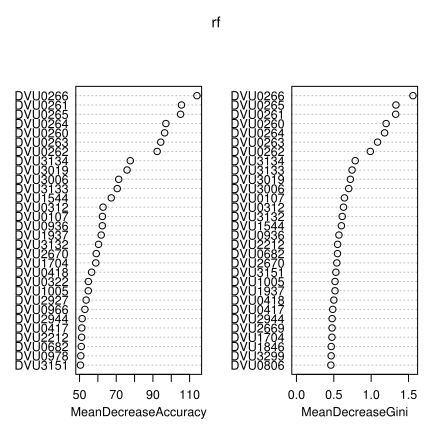

In [18]:
%%R
nlev = length(levels)
tmp = table(unlist(lapply(qqq$temperature,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp==length(qqq$temperature)])
rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
varImps = varImpPlot(rf) ##; print(rf)
varImps = varImps[ order(varImps[,1], decreasing=T), ]
imp_genes = rownames(varImps)[1:30]

In [19]:
%Rpull imp_genes

query = '%22'+'%22+%22'.join(imp_genes)+'%22'
query = 'http://networks.systemsbiology.net/search?q='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

http://networks.systemsbiology.net/search?q=%22DVU0266%22+%22DVU0261%22+%22DVU0265%22+%22DVU0264%22+%22DVU0260%22+%22DVU0263%22+%22DVU0262%22+%22DVU3134%22+%22DVU3019%22+%22DVU3006%22+%22DVU3133%22+%22DVU1544%22+%22DVU0312%22+%22DVU0107%22+%22DVU0936%22+%22DVU1937%22+%22DVU3132%22+%22DVU2670%22+%22DVU1704%22+%22DVU0418%22+%22DVU0322%22+%22DVU1005%22+%22DVU2927%22+%22DVU0966%22+%22DVU2944%22+%22DVU0417%22+%22DVU2212%22+%22DVU0682%22+%22DVU0978%22+%22DVU3151%22
